<a href="https://colab.research.google.com/github/as2c/MLP---Cosmology/blob/main/NN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, our objective is to train some neural network models on our test data.

### Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import timeit
import time
%alias_magic t timeit

plt.style.use('seaborn-talk')

from matplotlib import rcParams

# import warnings filter
from warnings import simplefilter 
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [ ]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 18
plt.rc('figure', figsize=(10,6))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

# Import phase I data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/denc_Neutrino')
# data['in_halo'] = (data['haloID']>0).astype('int')
data['in_halo'] = (data['halo_mass']>1600).astype('int32')
data

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,10156552,755,2280.0,171.21194,220.56293,-274.228700,-0.084922,-0.052028,-0.042415,-0.028087,-0.024984,-0.018675,-0.016231,-0.011940,-0.010111,1
1,11068486,85,1539.0,-129.84116,92.60424,212.125500,-0.127820,-0.081099,-0.051217,-0.028345,-0.013751,-0.013991,-0.012344,-0.011500,-0.012220,0
2,9530036,654,1944.0,-290.99210,-885.49430,468.255040,-0.078978,-0.052806,-0.030027,-0.011704,0.001295,0.003803,0.005131,0.005231,0.003787,1
3,11455022,752,1394.0,-60.35258,422.43716,79.394300,-0.109989,-0.079155,-0.054663,-0.037685,-0.026670,-0.017901,-0.009227,-0.000868,0.001568,0
4,8591034,356,1649.0,403.66608,345.88077,9.231552,-0.084405,-0.019068,-0.009396,-0.001539,0.002288,0.005629,0.011288,0.013111,0.013433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2160800,451,2634.0,654.82430,210.78130,255.344150,-0.094225,-0.076043,-0.060624,-0.040368,-0.020840,-0.016261,-0.011803,-0.005002,0.000918,1
99996,3257728,43,1112.0,-154.27774,488.65564,-779.558400,-0.127045,-0.076529,-0.056246,-0.038201,-0.027520,-0.016374,-0.008045,0.002627,0.006124,0
99997,6101605,484,1198.0,-113.51735,68.44336,275.964000,-0.122135,-0.091794,-0.063465,-0.032060,-0.017973,-0.016684,-0.017740,-0.017154,-0.012600,0
99998,4576456,44,1058.0,-130.21120,292.63483,-754.563000,-0.097585,-0.076140,-0.061788,-0.054584,-0.043055,-0.032415,-0.021591,-0.007463,0.004673,0


In [ ]:
data.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.716004e+06,424.627710,2369.299450,35.207601,-13.728656,97.821939,-0.107338,-0.062074,-0.038666,-0.025951,-0.017900,-0.011968,-0.007224,-0.003341,-0.000224,0.557930
std,3.549230e+06,230.962533,1856.527585,364.820655,369.919751,373.578625,0.020301,0.020965,0.019921,0.018106,0.015956,0.013969,0.012346,0.011069,0.010084,0.496635
min,2.131444e+06,16.000000,241.000000,-1247.932500,-1462.806300,-1250.519700,-0.127820,-0.099572,-0.083351,-0.072824,-0.065316,-0.058751,-0.050519,-0.043771,-0.038371,0.000000
25%,5.953820e+06,238.000000,1194.000000,-226.284345,-254.656135,-145.829085,-0.124202,-0.077891,-0.052474,-0.038510,-0.028860,-0.021233,-0.015384,-0.010712,-0.006964,0.000000
50%,9.043250e+06,418.000000,1791.000000,32.857450,-4.815737,101.883413,-0.113607,-0.063404,-0.039434,-0.026100,-0.017784,-0.011980,-0.007369,-0.003743,-0.000713,1.000000
75%,1.176120e+07,619.000000,2945.000000,284.168098,238.543252,350.062135,-0.095776,-0.048722,-0.025370,-0.013587,-0.006677,-0.002087,0.001081,0.004249,0.006694,1.000000
max,1.464652e+07,870.000000,10101.000000,1314.092800,1256.822900,1355.984900,0.017155,0.032463,0.044346,0.040490,0.042179,0.036009,0.033482,0.034145,0.032602,1.000000


### Visualize Data

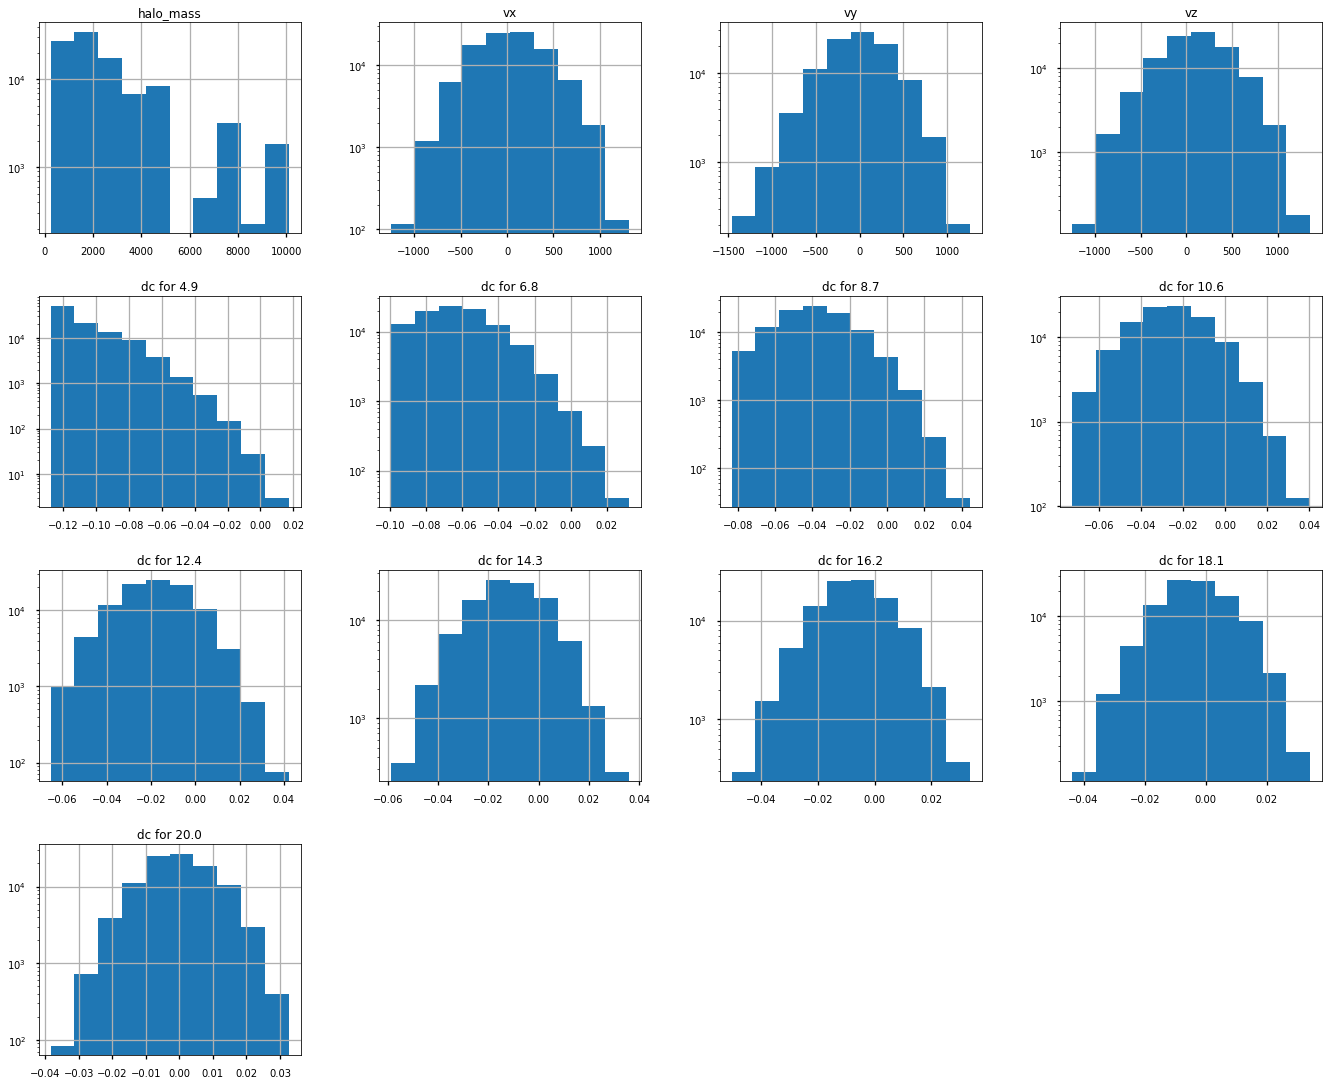

In [ ]:
data.iloc[:,2:15].hist(figsize=(23,19), log=True)
plt.show()

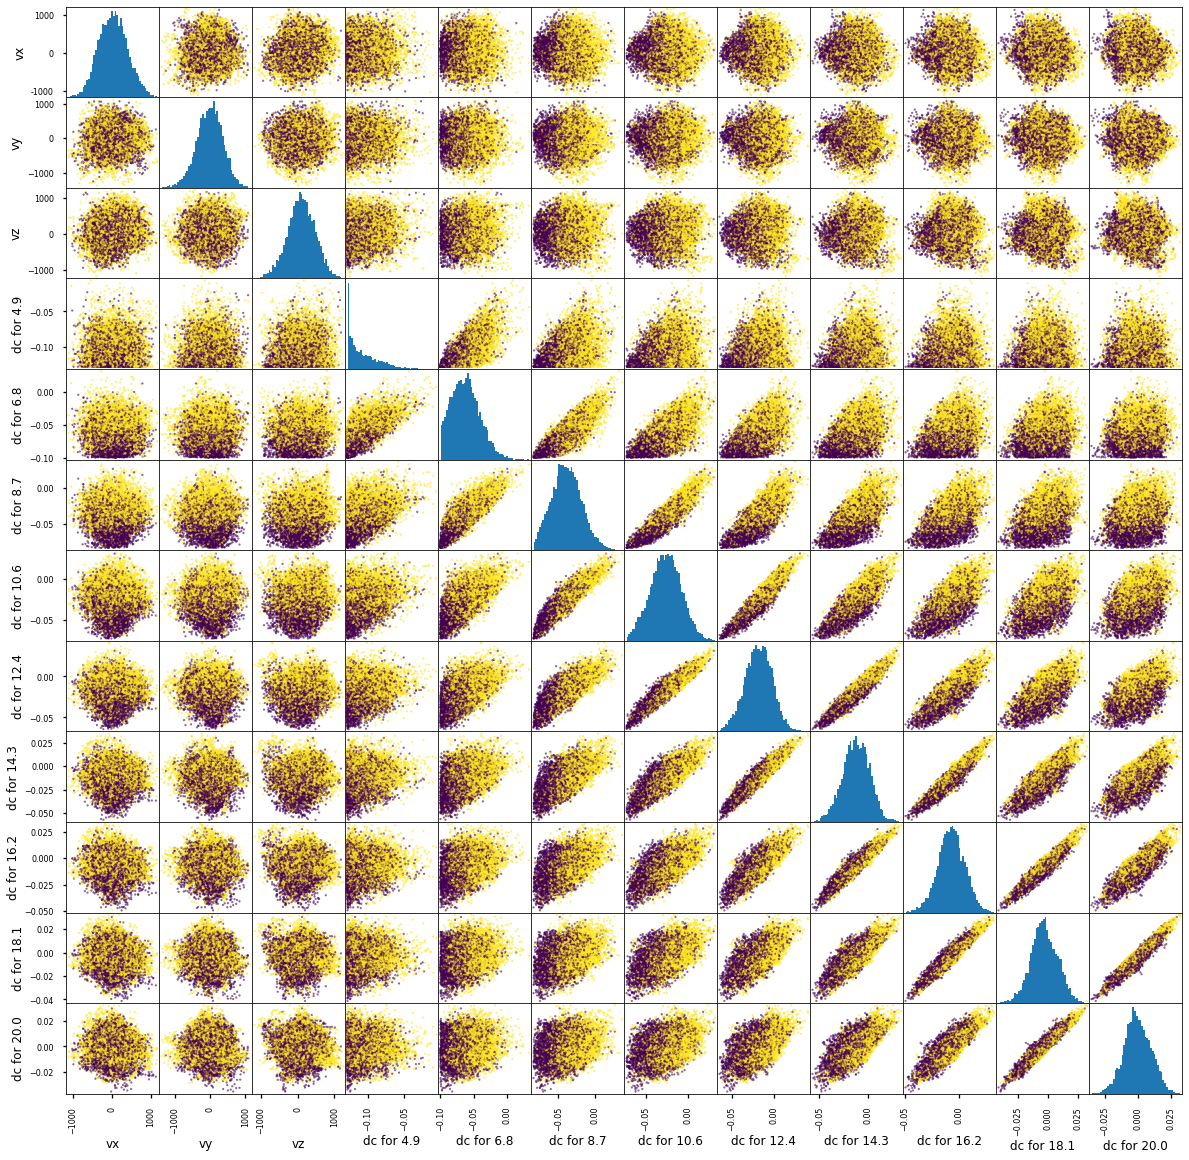

In [ ]:
N_sample=10_000
data_mini = data.sample(N_sample , random_state=0)
target = 'in_halo'

_=pd.plotting.scatter_matrix(data_mini.iloc[:,3:15], c=data_mini[target] , cmap = plt.cm.viridis,
                            figsize=(20,20), marker='o', s=5, 
                            hist_kwds={'bins':50} , alpha = .6)

### Define Datasets

In [ ]:
# data = data.sort_values( by =['dc for 12.4'])
X, Y = data.iloc[:,3:15], data.in_halo

In [ ]:
# Frequency of 1-class
print("{} % of the stored data has class 1 ".format(100*Y.sum()/len(Y)))

55.793 % of the stored data has class 1 


In [ ]:
# Scale data
# Think more about it
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

s_scaler = StandardScaler()
# m_scaler = MinMaxScaler()
# r_scaler = RobustScaler()

X = s_scaler.fit_transform(X)
# X = m_scaler.fit_transform(X)
# X = r_scaler.fit_transform(X)

In [ ]:
tst_size = 0.2
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 80000    X_test : 20000


In [ ]:
X_test,X_train = np.array(X_test),np.array(X_train)
Y_test,Y_train = np.array(Y_test),np.array(Y_train)
X ,Y= np.array(X),np.array(Y)
n_halo = len(set(data.haloID))
n_feat = 15 - 3
print(n_halo)

457


# Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

n_w = x_tr[0].size()
n_out = 10

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_feat, 30)  
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 10)
        self.out = nn.Linear(10, 1)
        


    def forward(self, x):
        # x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.hardtanh(self.fc2(x))
        x = F.elu(self.fc3(x))
        output = self.out(x)
        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=12, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


## Training

In [ ]:
net = Net()

optimizer = optim.Adam(net.parameters(), lr=.005, betas=(0.9, 0.999))
# optimizer = optim.RMSprop(net.parameters(), lr=.001, alpha=0.9)

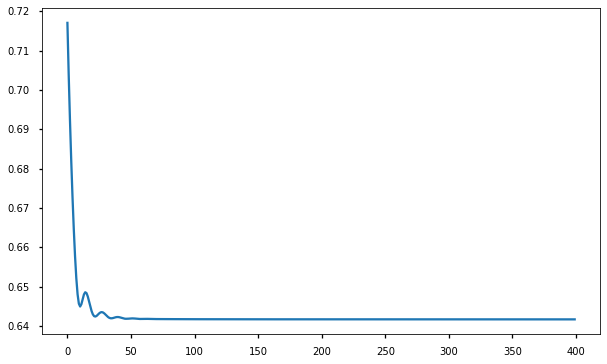

CPU times: user 16.8 s, sys: 615 ms, total: 17.4 s
Wall time: 17.3 s


In [ ]:
%%time
epochs = 400

#We also need to keep track of the loss. 
losses = []

for i in range(epochs):
    #Clear the previous gradients
    optimizer.zero_grad()
    
    #Precit the output for Given input
    y_pred = net.forward(x_tr)
    # y_tr = torch.reshape(y_tr, (65751,1))
    y_pred = torch.sigmoid(torch.reshape(y_pred, (-1,)))
    y_tr = torch.reshape(y_tr, (-1,))#.to(torch.float32)
    loss = nn.BCELoss()
    l = loss(y_pred, y_tr)
    losses += [l]

    l.backward()
    optimizer.step()
    
plt.plot(losses)
plt.show()

## Minibatch


In [ ]:
# del net
net = Net()
optimizer = optim.Adam(net.parameters(), lr=.01)
criterion = nn.NLLLoss()

In [ ]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

In [ ]:
(net.forward(x_ts).argmax(axis=1)==y_ts).sum()/len(y_ts)
# net.forward(x_ts).argmax(axis=1)

tensor(0.4426)

In [ ]:
n_epoch=3
btch_size = 1000

### Data Loaders

In [ ]:
## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)

In [ ]:
training_dataset[0]

(tensor([-0.5436, -1.2004, -1.7165,  0.3404,  1.2351,  0.3986,  0.3124, -0.2346,
         -0.1404, -0.3011, -0.5421, -0.5848]), tensor(1, dtype=torch.int32))

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
for x, y in train_loader:
  print(x.size() )
  # plt.imshow(x[0].numpy())
  print(y[0])
  break

torch.Size([1000, 12])
tensor(1, dtype=torch.int32)


### Training

In [ ]:
%%time
# epochs = 3
# batch_size = 500
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss. 
sample_rate = 10
training_losses = []
test_losses = []

training_accuracy = []
test_accuracy = []

for i in range(n_epoch):
  print(f'Starting {i} epoch.')
  # print(len(training_losses))
  ind = 0

  for i, (X_batch, Y_batch) in enumerate(train_loader):
    # X_batch = X_batch.reshape(-1, n_w*n_h)#.to(device)
    Y_batch = Y_batch#.to(device)
    ind += 1

    # Forward pass
    # #Precit the output for Given input
    outputs = net(X_batch)
    outputs = torch.reshape(outputs, (-1,))
    Y_batch = torch.reshape(Y_batch, (-1,))
    loss = nn.BCELoss()
    l = loss(outputs, Y_batch)
    
    # Backward and optimize
    #Clear the previous gradients
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    ## Every sample_rate, we record the loss and accuracy. 
    if ind%(int(n_s/btch_size/sample_rate))==0:
      y_tr_pred = net.forward(x_tr)
      training_losses += [F.nll_loss( y_tr_pred, y_tr).item() ]
      training_accuracy += [torch.sum( y_tr == 
                                      torch.argmax( y_tr_pred, axis=1 ) ).item()/n_s ]

      # print(F.nll_loss( net.forward(x_ts) , y_ts) )
      y_ts_pred = net.forward(x_ts)
      test_losses += [F.nll_loss( y_ts_pred, y_ts).item() ]
      test_accuracy += [torch.sum( y_ts == 
                                      torch.argmax( y_ts_pred, axis=1 )).item()/n_ts ]





Starting 0 epoch.


RuntimeError: ignored

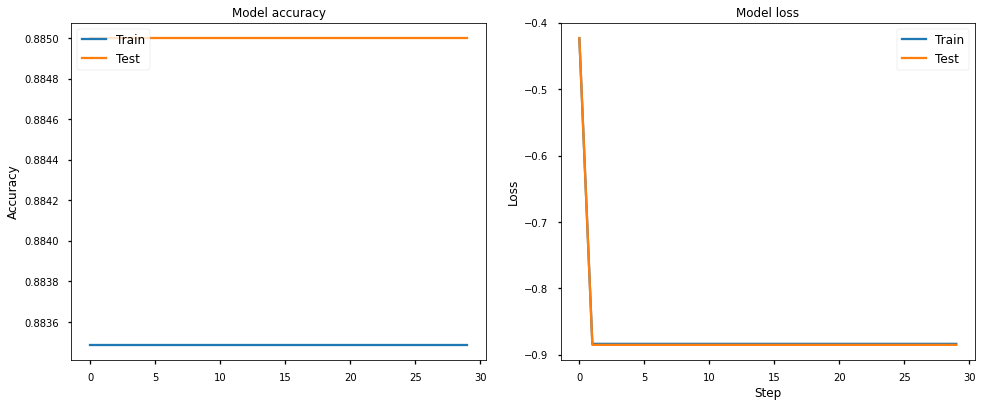

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()

## Minibatch correct


In [ ]:
# del net
net = Net()
optimizer = optim.Adam(net.parameters(),lr=learning_rate)
criterion = nn.NLLLoss()

In [ ]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

In [ ]:
(net.forward(x_ts).argmax(axis=1)==y_ts).sum()/len(y_ts)
# net.forward(x_ts).argmax(axis=1)

tensor(0.4421)

In [ ]:
n_epoch=3
btch_size = 1000

### Data Loaders

In [ ]:
## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)

In [ ]:
training_dataset[0]

(tensor([-0.5234, -2.0080, -1.6659, -1.0064, -0.4587, -0.0681,  0.1226,  0.0534,
         -0.2232, -0.6957, -0.9125, -0.9765]), tensor(0, dtype=torch.int32))

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
for x, y in train_loader:
  print(x.size() )
  # plt.imshow(x[0].numpy())
  print(y[0])
  break

torch.Size([1000, 12])
tensor(1, dtype=torch.int32)


### Training

In [ ]:
%%time
# epochs = 3
# batch_size = 500
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss. 
sample_rate = 10
training_losses = []
test_losses = []

training_accuracy = []
test_accuracy = []

for i in range(n_epoch):
  print(f'Starting {i} epoch.')
  # print(len(training_losses))
  ind = 0

  for i, (X_batch, Y_batch) in enumerate(train_loader):
    # X_batch = X_batch.reshape(-1, n_w*n_h)#.to(device)
    # X_batch = torch.reshape(X_batch, (-1,))

    Y_batch = Y_batch#.to(device)
    ind += 1

    # Forward pass
    # #Precit the output for Given input
    outputs = net(X_batch)
    # outputs = torch.reshape(outputs, (-1,))
    # Y_batch = torch.reshape(Y_batch, (-1,))
    # loss = criterion(outputs, Y_batch)
    
    outputs = torch.reshape(outputs, (-1,))
    Y_batch = torch.reshape(Y_batch, (-1,))
    # print(outputs)
    # print(Y_batch)
    loss = F.nll_loss(outputs, Y_batch.long())

    # Backward and optimize
    #Clear the previous gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## Every sample_rate, we record the loss and accuracy. 
    
    if ind%(int(n_s/btch_size/sample_rate))==0:
      y_tr_pred = net.forward(x_tr)
      y_tr_pred = torch.reshape(y_tr_pred, (-1,))
      y_tr = torch.reshape(y_tr, (-1,))
      training_losses += [F.nll_loss( y_tr_pred, y_tr.long()).item() ]
      training_accuracy += [torch.sum( y_tr == 
                                      torch.argmax( y_tr_pred, axis=0 ) ).item()/n_s ]
      # print("joooje")
      # print(F.nll_loss( net.forward(x_ts) , y_ts) )
      y_ts_pred = net.forward(x_ts)
      y_ts_pred = torch.reshape(y_ts_pred, (-1,))
      y_ts = torch.reshape(y_ts, (-1,))
      test_losses += [F.nll_loss( y_ts_pred, y_ts.long()).item() ]
      test_accuracy += [torch.sum( y_ts == 
                                      torch.argmax( y_ts_pred, axis=0 )).item()/n_ts ]





Starting 0 epoch.
Starting 1 epoch.
Starting 2 epoch.
CPU times: user 2.49 s, sys: 48.1 ms, total: 2.54 s
Wall time: 2.55 s


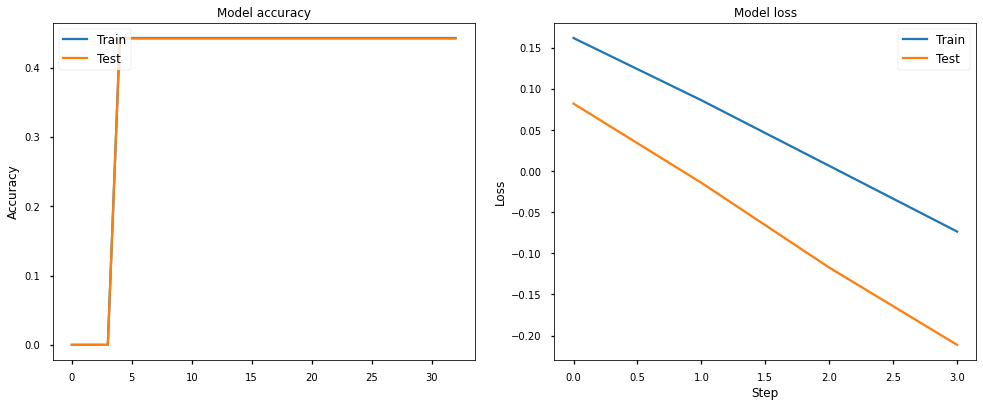

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()

## GPU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_epoch=3
btch_size = 1000

x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)




In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
%%time
n_w = x_tr[0].size()
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss. 
sample_rate = 20
training_losses = []
test_losses = []

training_accuracy = []
test_accuracy = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = NeuralNet(n_w * n_h, [100,80], 10).to(device)
model = Net().to(device)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

# Train the model
total_step = len(train_loader)
for epoch in range(n_epoch):
    print(f'Starting {epoch} epoch.')

    for i, (X_batch, Y_batch) in enumerate(train_loader):  
        # Move tensors to the configured device
        # X_batch = X_batch.reshape(-1, n_w).to(device)
        Y_batch = Y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            

        ## Every sample_rate, we record the loss and accuracy. 
        if i%(int(n_s/btch_size/sample_rate))==0:
          y_tr_pred = model.forward(x_tr.to(device)).cpu()
          training_losses += [F.nll_loss( y_tr_pred, y_tr).item() ]
          training_accuracy += [torch.sum( y_tr == 
                                          torch.argmax( y_tr_pred, axis=1 ) ).item()/n_s ]

          # print(F.nll_loss( net.forward(x_ts) , y_ts) )
          y_ts_pred = model.forward(x_ts.to(device)).cpu()
          test_losses += [F.nll_loss( y_ts_pred, y_ts).item() ]
          test_accuracy += [torch.sum( y_ts == 
                                          torch.argmax( y_ts_pred, axis=1 )).item()/n_ts ]
      

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Starting 0 epoch.
Starting 1 epoch.
Starting 2 epoch.
Accuracy of the network on the 10000 test images: 88.5 %
CPU times: user 1min 26s, sys: 1.04 s, total: 1min 27s
Wall time: 1min 27s


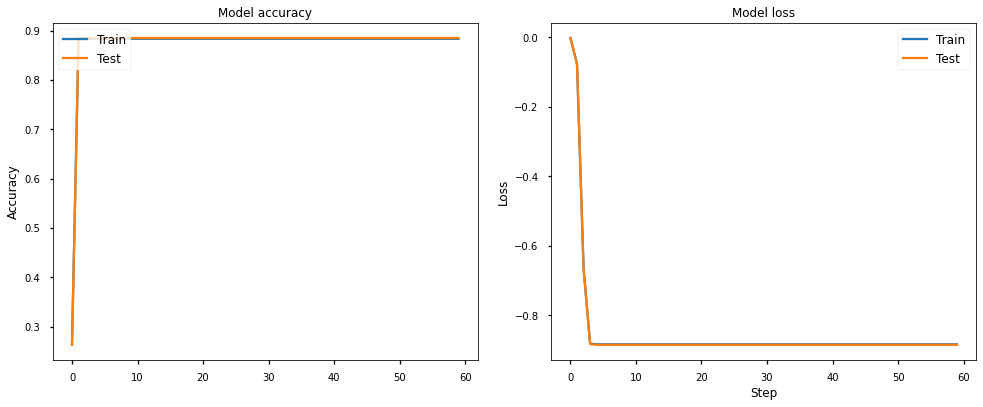

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()